### 🤖 LLM and AI Agent Development Courses  
**✨ All courses available for just ₹399 INR / $9.99 USD ✨**

| Course | Description | Enroll |
|--------|-------------|---------|
| **🎯 Master OpenAI Agent Builder** | Build and deploy AI agents visually using OpenAI Agent Builder, ChatKit, RAG, Chatbot, AI Assistant with MCP, AWS, RDS MySQL | [Enroll Now](https://kgptalkie.com/agent-builder) |
| **🔥 MCP Mastery** | Build MCP servers & clients with Python, Streamlit, ChromaDB, LangChain, LangGraph agents, and Ollama integrations | [Enroll Now](https://kgptalkie.com/mcp) |
| **📊 Private Agentic RAG with LangChain** | Step-by-Step Guide to RAG with LangChain v1, LangGraph, and Ollama (Qwen3, Gemma3, DeepSeek-R1, LLAMA, FAISS) | [Enroll Now](https://kgptalkie.com/agentic-rag) |
| **🔧 Master LangGraph and LangChain** | Agentic RAG and Chatbot, AI Agent with LangChain v1, Qwen3, Gemma3, DeepSeek-R1, LLAMA 3.2, FAISS Vector Database | [Enroll Now](https://kgptalkie.com/langgraph) |
| **⚡ Master Langchain and Ollama** | Master Langchain v1, Local LLM Projects with Ollama, Qwen3, Gemma3, DeepSeek-R1, LLAMA 3.2, Complete Integration Guide | [Enroll Now](https://kgptalkie.com/langchain) |
| **🔬 Fine Tuning LLM** | Learn transformer architecture fundamentals and fine-tune LLMs with custom datasets | [Enroll Now](https://kgptalkie.com/fine-tuning-llm) |

---

### 🌐 Join the Community & Stay Connected

- 🔗 **Join the Discord Community:** https://discord.gg/RFjwbkNa  
- 📺 **Subscribe on YouTube (63K+ learners):** http://www.youtube.com/@KGPTalkie

---


## Reflection Agent - Researcher and Self-Critique Agents
### Web Research with Iterative Self-Improvement

Learning Objectives:
- Build a research agent with web search
- Implement critique agent for quality control
- Use reflection loop with max iterations

#### Real-World Use Cases:
1. **Content Research**: Gather and refine information
2. **Report Generation**: Iteratively improve quality
3. **Fact Checking**: Verify and enhance accuracy
4. **Competitive Analysis**: Research and critique findings

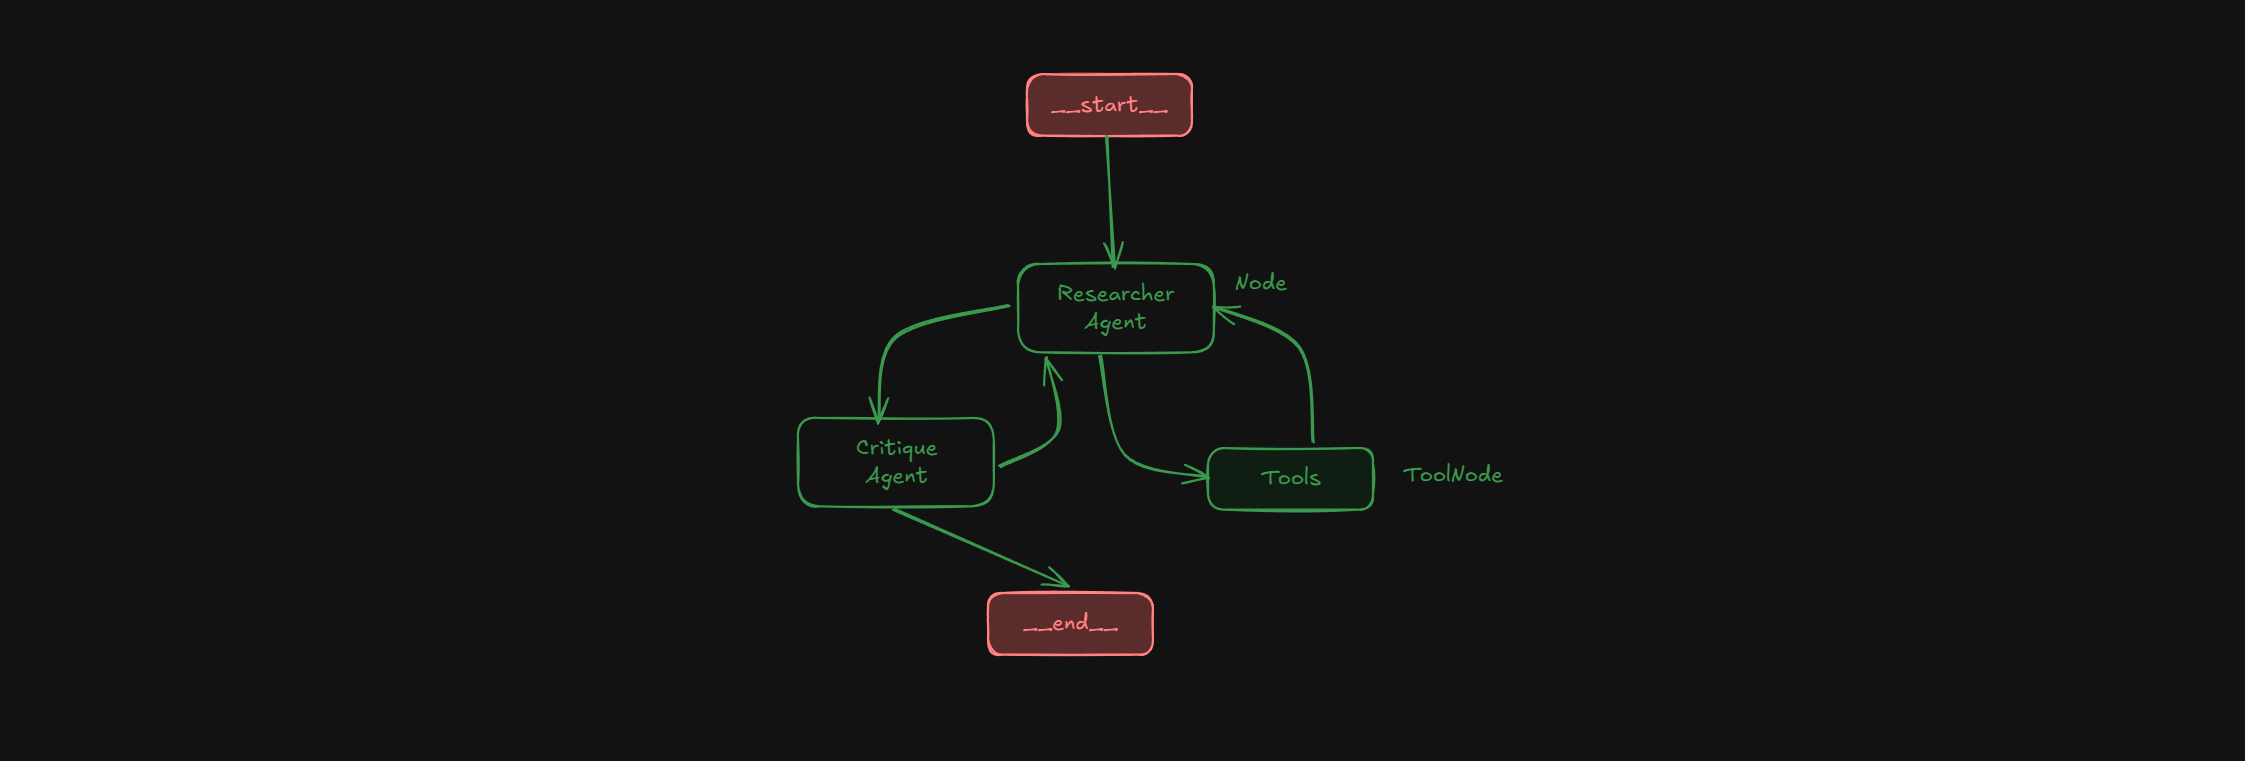

In [ ]:
from dotenv import load_dotenv

load_dotenv()

In [ ]:
from typing_extensions import TypedDict, Annotated
import operator
from langgraph.graph import StateGraph, START, END

from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

# Configuration
BASE_URL = "http://localhost:11434"
MODEL_NAME = "qwen3" #gpt-oss

llm = ChatOllama(model=MODEL_NAME, base_url=BASE_URL)

### Web Search Tool

In [ ]:
# tavily search dev serper, ddgs
from ddgs import DDGS

@tool
def web_search(query:str, num_results: int = 10) -> str:
    """Use this tool whenever you need to access realtime or latest information.
        Search the web using DuckDuckGo.
    
    Args:
        query: Search query string
        num_results: Number of results to return (default: 5)
    
    Returns:
        Formatted search results with titles, descriptions, and URLs
    """

    results = DDGS().text(query=query, max_results=num_results, region='us-en')

    if not results:
        return f"No results found for '{query}'"
    
    formatted_results = [f"Search results for search query: '{query}'"]
    for i, result in enumerate(results, 1):
        title = result.get('title', 'No title')
        href = result.get('href', '')
        body = result.get('body', 'No description available')
        
        text = f"{i}. **{title}**\n   {body}\n   {href}"
        
        formatted_results.append(text)

    return "\n\n".join(formatted_results)

In [ ]:
result = web_search.invoke({'query': 'python tutorial', 'num_results':3})
print(result)

In [ ]:
from ddgs import DDGS

results = DDGS().text("python programming", max_results=5)
print(results)

### Agent State

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[list, operator.add]
    research: str
    critique: str
    iterations: int # track the iteration to avoid infinite loop


### Researcher Node

In [ ]:
def researcher_node(state: AgentState):
    
    llm_with_tools = llm.bind_tools([web_search])

    critique = state.get('critique', '')
    iteration = state.get('iterations', 0)

    feedback_prompt = ""
    if critique:
        feedback_prompt = f"""
                Previous Critique: {critique}
                Address the missing points with new search queries.
                """

    system_prompt = SystemMessage(f"""
        You are a research agent with web search capabilities.
        {feedback_prompt}
        INSTRUCTIONS:
        1. **MUST use web_search tool** first to gather information
        2. Provide comprehensive research based on search results

        Always call **web_search** before responding.
    """)

    messages = [system_prompt] + state['messages']

    response = llm_with_tools.invoke(messages)

    if hasattr(response, 'tool_calls') and response.tool_calls:
        for tc in response.tool_calls:
            print(f"[RESEARCHER] called Tool {tc.get('name', '?')} with args {tc.get('args', '?')}")
    else:
        print(f"[RESEARCHER] Responding with iteration number: {iteration + 1}")
    
    return {"messages": [response]}

### Critique Node

<!-- You are a critique agent. Evaluate research quality briefly.

        Criteria:
        1. Completeness - fully answered?
        2. Depth - enough detail?
        3. Accuracy - correct information?

        Format:
        DECISION: APPROVE or REVISE
        If REVISE: List 1-2 specific missing points only.

        Keep it short and focused. **Also instruct the researcher to must use web_search tool in the next iteration.** -->

In [ ]:
def critique_node(state: AgentState):

    messages = state['messages']
    iteration = state['iterations']

    research_content = messages[-1].content

    system_prompt = SystemMessage("""
        You are a critique agent. Evaluate if research is good enough.
        
        Check:
        1. Does it answer the main question?
        2. Is there reasonable detail?
        
        Response Format:
        DECISION: APPROVE or REVISE
        
        Be lenient. APPROVE if research is decent enough.
        Only REVISE if critical information is completely missing.
    """)

    critique_prompt = HumanMessage(f"""
                                    Evaluate this research:
                                   {research_content}
                                   """)
    
    messages = [system_prompt, critique_prompt]

    response = llm.invoke(messages)

    print(f"[CRITIQUE] Iteration {iteration + 1}")

    return {
        "critique": response.content,
        'research': research_content,
        'iteration': iteration + 1
    }

### Routing Logic

In [ ]:
def should_continue(state: AgentState):
    last = state['messages'][-1]
    
    if hasattr(last, 'tool_calls') and last.tool_calls:
        return "tools"
    else:
        return "critique"

In [ ]:
MAX_ITERATIONS = 10
def check_approval(state:AgentState):
    critique = state.get('critique', '')
    iterations = state.get('iterations', 0)

    if iterations >= MAX_ITERATIONS:
        print(f"[SYSTEM] Max iterations ({MAX_ITERATIONS}) reached. Stopping...")
        return END
    
    if 'APPROVE' in critique.upper():
        print(f"[SYSTEM] Research approved after ({iterations} iterations).")
        return END
    
    else:
        print(f"[SYSTEM] Revision needed. continuing iteration {iterations + 1}")
        return "researcher"

### Build Graph

In [ ]:
def create_agent():

    builder = StateGraph(AgentState)

    # add nodes
    builder.add_node('researcher', researcher_node)
    builder.add_node('critique', critique_node)
    builder.add_node('tools', ToolNode([web_search]))

    # add edges
    builder.add_edge(START, 'researcher')
    builder.add_conditional_edges('researcher', should_continue, ['tools', 'critique'])
    builder.add_edge('tools', 'researcher')
    builder.add_conditional_edges('critique', check_approval, ['researcher', END])

    graph = builder.compile()

    return graph


agent = create_agent()
agent


### Run Agent

In [ ]:
query = "What are the latest developements in the LangGraph for building AI Agents?"

result = agent.invoke({'messages': [HumanMessage(query)], 'iterations':0})

print(result['research'])

In [ ]:
result

In [ ]:
query = "What is the latest stock price outlook in 2025 and 2026 for Tesla and Apple?"

result = agent.invoke({'messages': [HumanMessage(query)], 'iterations':0})

print(result['research'])